# Clustering based on chrom5k CGN

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

from ALLCools.clustering import \
    tsne, \
    significant_pc_test, \
    filter_regions, \
    remove_black_list_region, \
    lsi, \
    binarize_matrix
from ALLCools.plot import *
from ALLCools.mcds import MCDS

In [2]:
import os
os.chdir("/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/snm3c/hh_micro_mono/")

In [3]:
hh_adata = sc.read_h5ad("/tscc/projects/ps-renlab2/sel041/scmethylhic/human_hippocampus/concat/human_aging_5kb-CGN-hypo_cluster_bbknn_filtered_annotated_revision4.h5ad")

In [4]:
# metadata_path = "dHIP_map3c_meta.tsv"
mcds_path = "HumanCellEpigenomAtlas_Mono_2/HCEA_PBMC_mono2.mcds/"
chunks = {"cell": 100, "mc_type": 1, "count_type": 1}

# PC cutoff
pc_cutoff = 0.1

resolution = 1

In [5]:
mcds = MCDS.open(mcds_path, var_dim="chrom5k", chunks=chunks)
# mcds.add_cell_metadata(metadata)

In [6]:
mcds

<xarray.MCDS>
Dimensions:                    (cell: 330, chrom5k: 642094, count_type: 2,
                                mc_type: 3)
Coordinates:
  * cell                       (cell) <U26 'PBMC_4809_Plate3-3-O9-J6' ... 'PB...
  * chrom5k                    (chrom5k) <U27 'chr1_0' ... 'chrY_KI270740v1_r...
    chrom5k_chrom              (chrom5k) <U23 dask.array<chunksize=(642094,), meta=np.ndarray>
    chrom5k_end                (chrom5k) int64 dask.array<chunksize=(642094,), meta=np.ndarray>
    chrom5k_start              (chrom5k) int64 dask.array<chunksize=(642094,), meta=np.ndarray>
  * count_type                 (count_type) <U3 'mc' 'cov'
  * mc_type                    (mc_type) <U3 'CGN' 'CAN' 'CHN'
Data variables:
    chrom5k_da                 (cell, chrom5k, mc_type, count_type) uint32 dask.array<chunksize=(100, 642094, 1, 1), meta=np.ndarray>
    chrom5k_da_CGN-hypo-score  (cell, chrom5k) float16 dask.array<chunksize=(100, 642094), meta=np.ndarray>
    chrom5k_da_CHN-hypo-score  (cell, chrom5k) float16 dask.array<chunksize=(100, 642094), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom5k

In [7]:
# blacklist
black_list_path = "/tscc/projects/ps-epigen/users/biy022/scmethylhic/genome/genome_hg38/hg38_blacklist.v2.bed.gz"
black_list_fraction = 0.2
mcds = mcds.remove_black_list_region(black_list_path=black_list_path)

45816 chrom5k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


In [8]:
chrom_to_remove = ["chrX", "chrY", "chrM", "chrL"]
mcds = mcds.remove_chromosome(chrom_to_remove)

34487 chrom5k features in ['chrX', 'chrY', 'chrM', 'chrL'] removed.


In [9]:
mcad = mcds.get_score_adata(mc_type="CGN", quant_type="hypo-score")

Loading chunk 0-330/330


In [10]:
shared_regions = mcad.var_names.intersection(hh_adata.var_names)
mcad = mcad[:, shared_regions].copy()
hh_adata = hh_adata[:, shared_regions].copy()

In [11]:
len(shared_regions)

422970

In [12]:
mcad = mcad.concatenate([hh_adata], index_unique="-")

/tscc/nfs/home/biy022/miniconda3/envs/allcools/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [13]:
mcad.obs["final_cluster"] = mcad.obs["final_cluster"].astype(str)
mcad.obs.loc[mcad.obs["final_cluster"] == "nan", "final_cluster"] = "Monocytes"

In [14]:
binarize_matrix(mcad, cutoff=0.95)

In [15]:
filter_regions(mcad)

165379 regions remained.


## LSI decomposition

In [16]:
lsi(mcad, algorithm="arpack", obsm="X_pca")
n_components = significant_pc_test(mcad, p_cutoff=pc_cutoff, update=True)

31 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (22570, 100) to (22570, 31)


In [17]:
sc.pp.neighbors(mcad)
sc.tl.leiden(mcad, resolution=resolution)

In [18]:
try:
    sc.tl.paga(mcad, groups="leiden")
    sc.pl.paga(mcad, plot=False)
    sc.tl.umap(mcad, init_pos="paga")
except:
    sc.tl.umap(mcad)

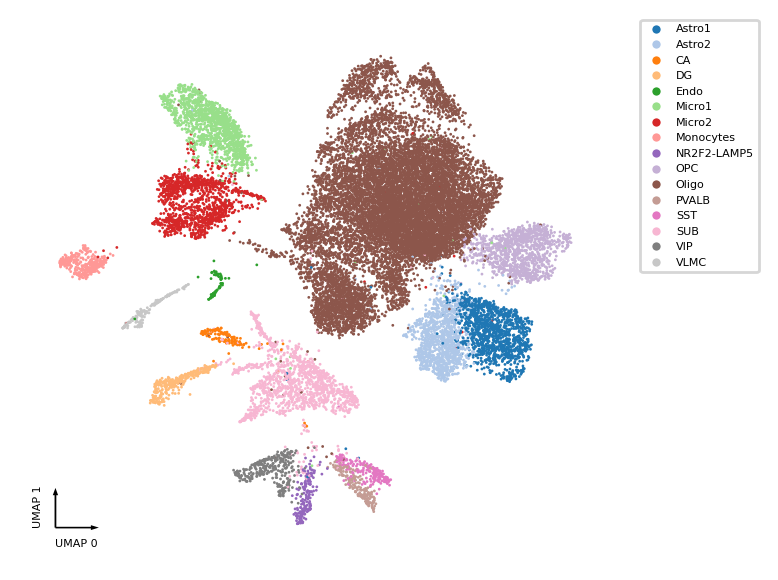

In [19]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
_ = categorical_scatter(data=mcad, ax=ax, coord_base="umap", hue="final_cluster", show_legend=True)
plt.tight_layout()

In [22]:
mcad.obs = mcad.obs[["final_cluster"]].copy()
mcad.write_h5ad("hh_mono_CGN_chrom5k.mcad")

## Consensus clustering

In [1]:
import pathlib
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ALLCools.clustering import ConsensusClustering, Dendrogram, get_pc_centers
from ALLCools.plot import *

In [2]:
# clustering name
clustering_name = "L1"

# input data
# cell_meta_path = "dHIP_map3c_meta.tsv"
adata_path = "hh_mono_CGN_chrom5k.mcad"
coord_base = "umap"

# ConsensusClustering
n_neighbors = 25
metric = "euclidean"
min_cluster_size = 10
consensus_rate = 0.5
leiden_repeats = 500
leiden_resolution = 0.5
random_state = 0
n_jobs = 40
train_frac = 0.5
train_max_n = 500
max_iter = 20

# Dendrogram via Multiscale Bootstrap Resampling
nboot = 10000
method_dist = "correlation"
method_hclust = "average"

plot_type = "static"

In [3]:
# cell_meta = pd.read_csv(cell_meta_path, index_col=0, sep="\t")
adata = anndata.read_h5ad(adata_path)

In [26]:
cc = ConsensusClustering(
    model=None,
    n_neighbors=n_neighbors,
    metric=metric,
    min_cluster_size=min_cluster_size,
    leiden_repeats=leiden_repeats,
    leiden_resolution=leiden_resolution,
    consensus_rate=consensus_rate,
    random_state=random_state,
    train_frac=train_frac,
    train_max_n=train_max_n,
    max_iter=max_iter,
    n_jobs=n_jobs
)

In [28]:
if "X_pca" not in adata.obsm:
    raise KeyError(
        "X_pca do not exist in the adata file, run PCA first before clustering."
    )
cc.fit_predict(adata.obsm["X_pca"])

Computing nearest neighbor graph
Computing multiple clustering with different random seeds
Repeating leiden clustering 500 times
Found 17 - 18 clusters, mean 17.8, std 0.42
Summarizing multiple clustering results
22567 cells assigned to 19 raw clusters
3 cells are multi-leiden outliers

=== Start supervise model training and cluster merging ===

=== iteration 1 ===
19 non-outlier labels
Balanced accuracy on the training set: 0.945
Balanced accuracy on the hold-out set: 0.936
Merging 3 clusters.

=== iteration 2 ===
16 non-outlier labels
Balanced accuracy on the training set: 0.980
Balanced accuracy on the hold-out set: 0.973
Stop iteration because current accuracy 0.973 > target accuracy 0.950.

=== Assign final labels ===
Assigned all the multi-leiden clustering outliers into clusters using the prediction model from final clustering version.
Final ten-fold CV Accuracy on all the cells: 0.971


In [29]:
adata.obs[f"{coord_base}_0"] = adata.obsm[f"X_{coord_base}"][:, 0]
adata.obs[f"{coord_base}_1"] = adata.obsm[f"X_{coord_base}"][:, 1]

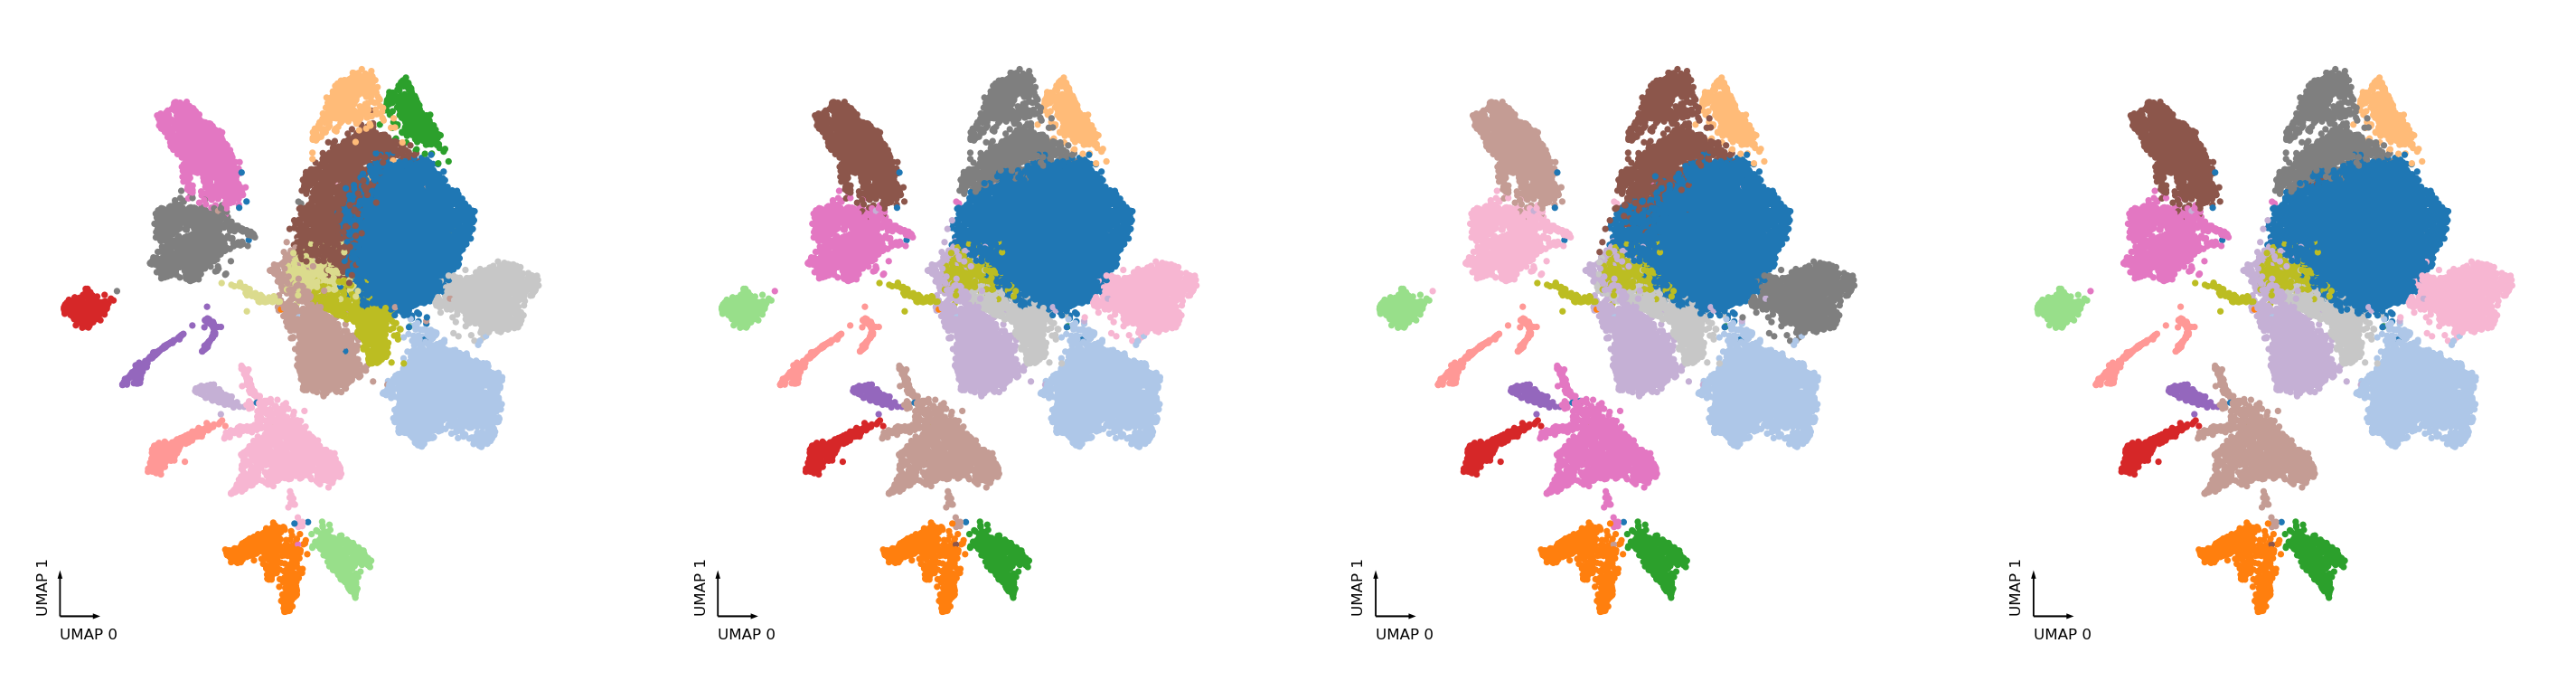

In [30]:
fig, axes = cc.plot_leiden_cases(
    coord_data=adata.obs,
    coord_base=coord_base
)

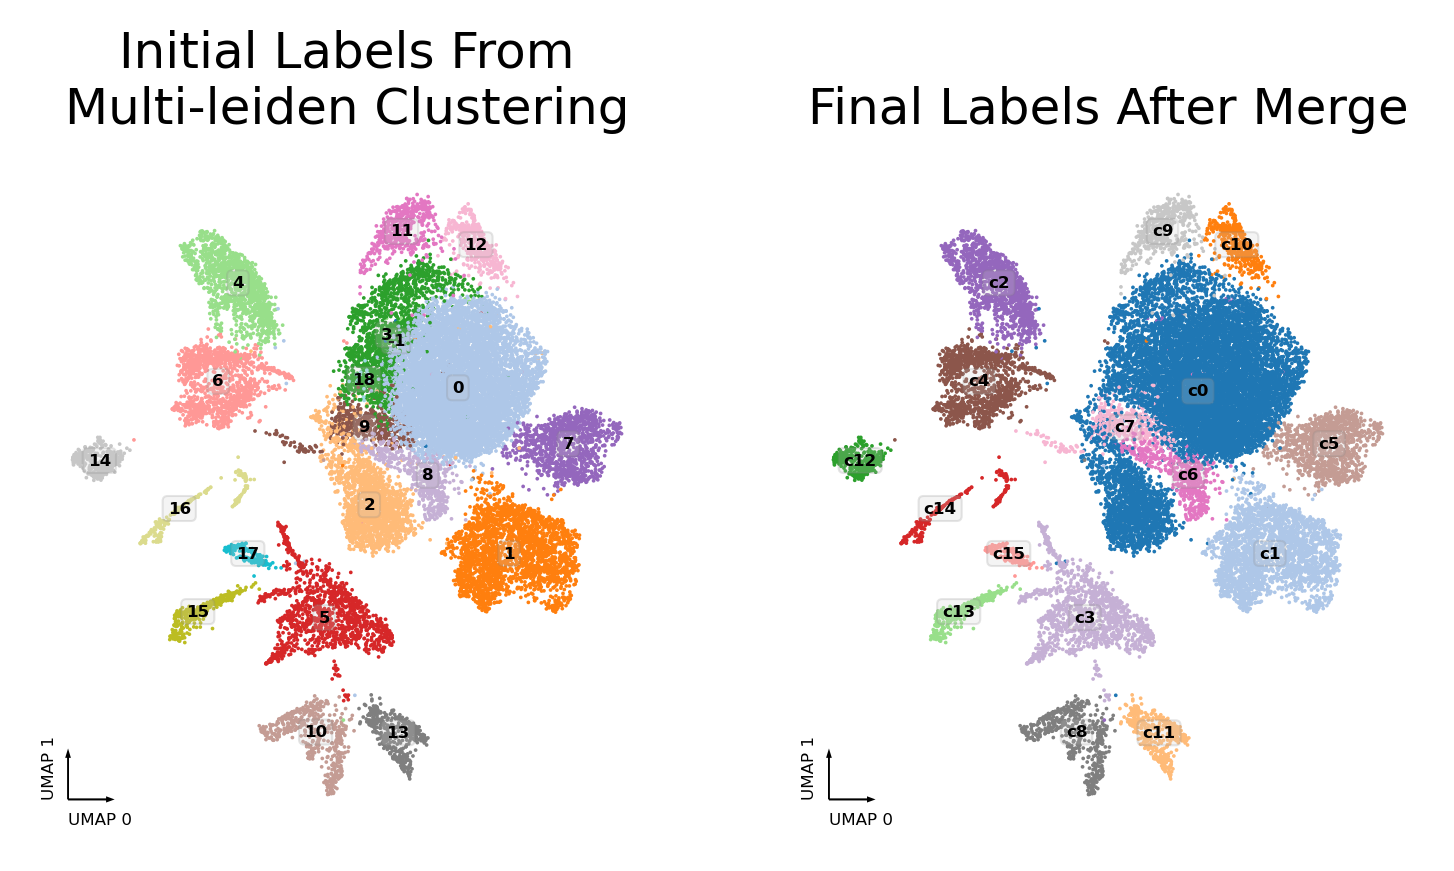

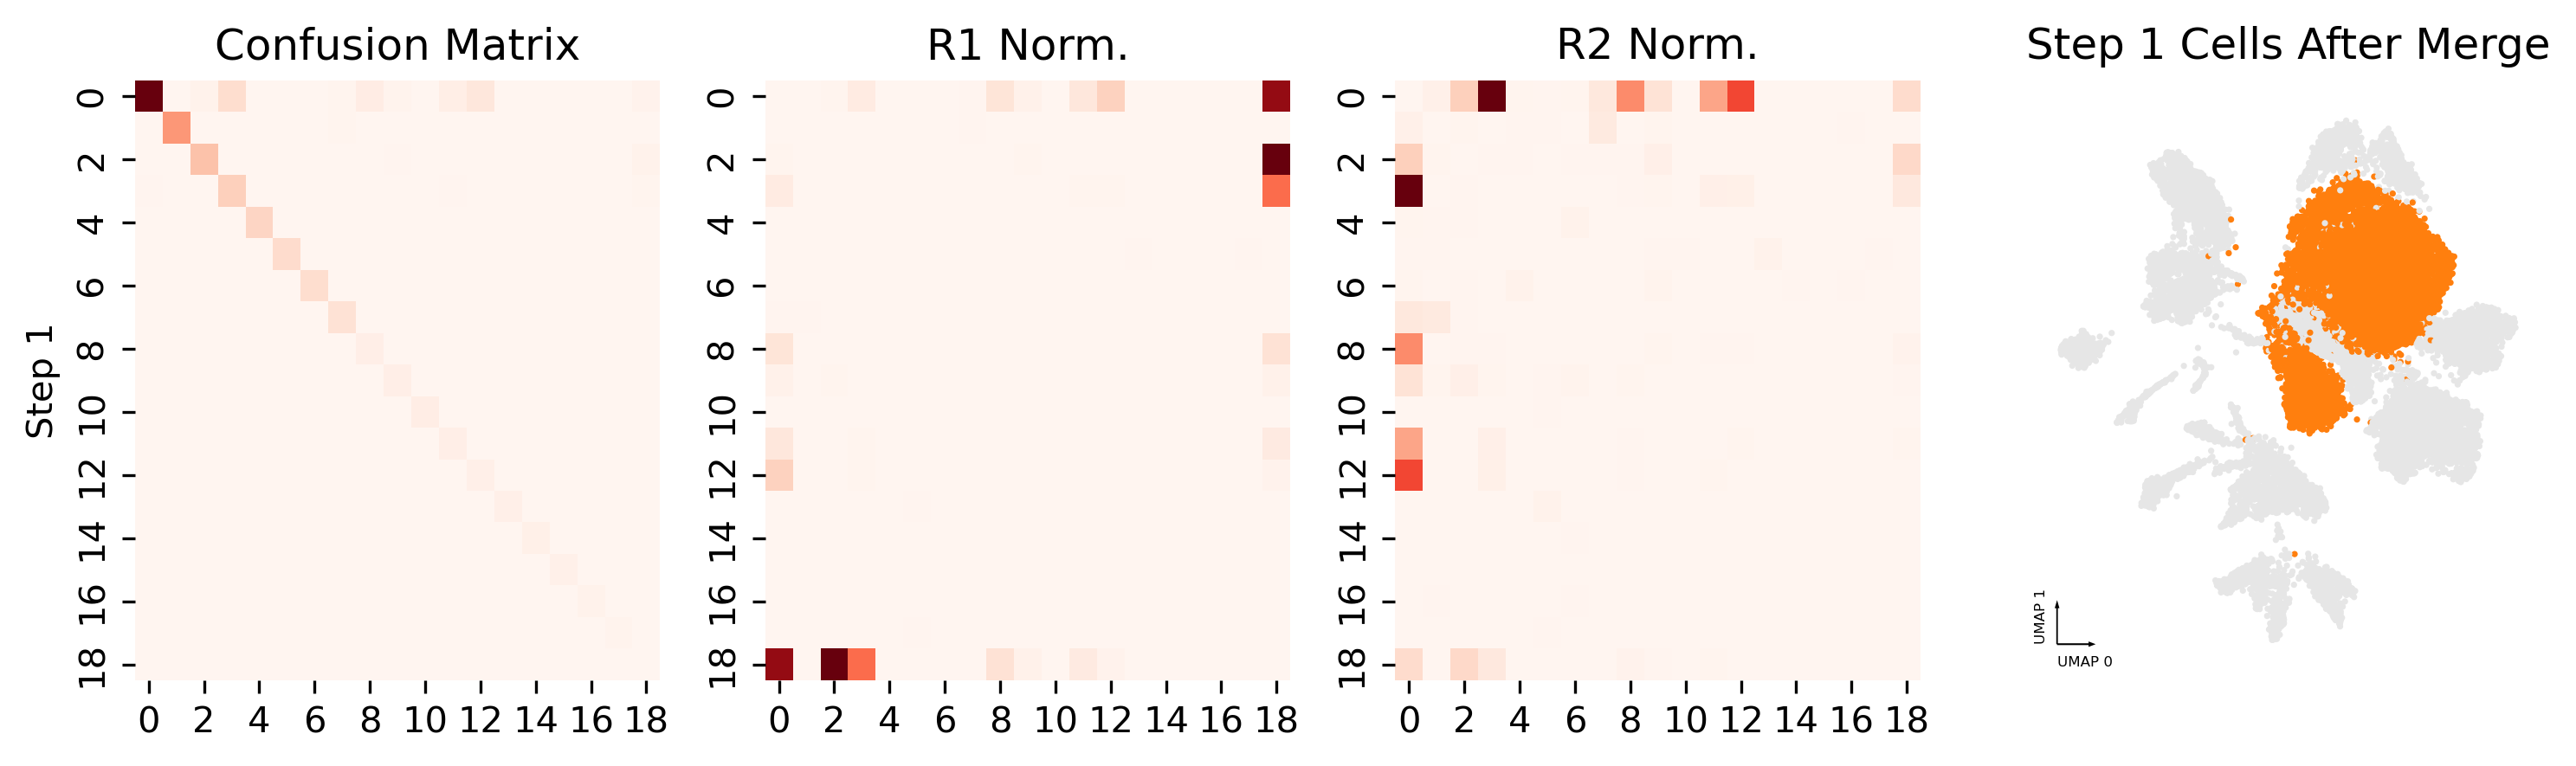

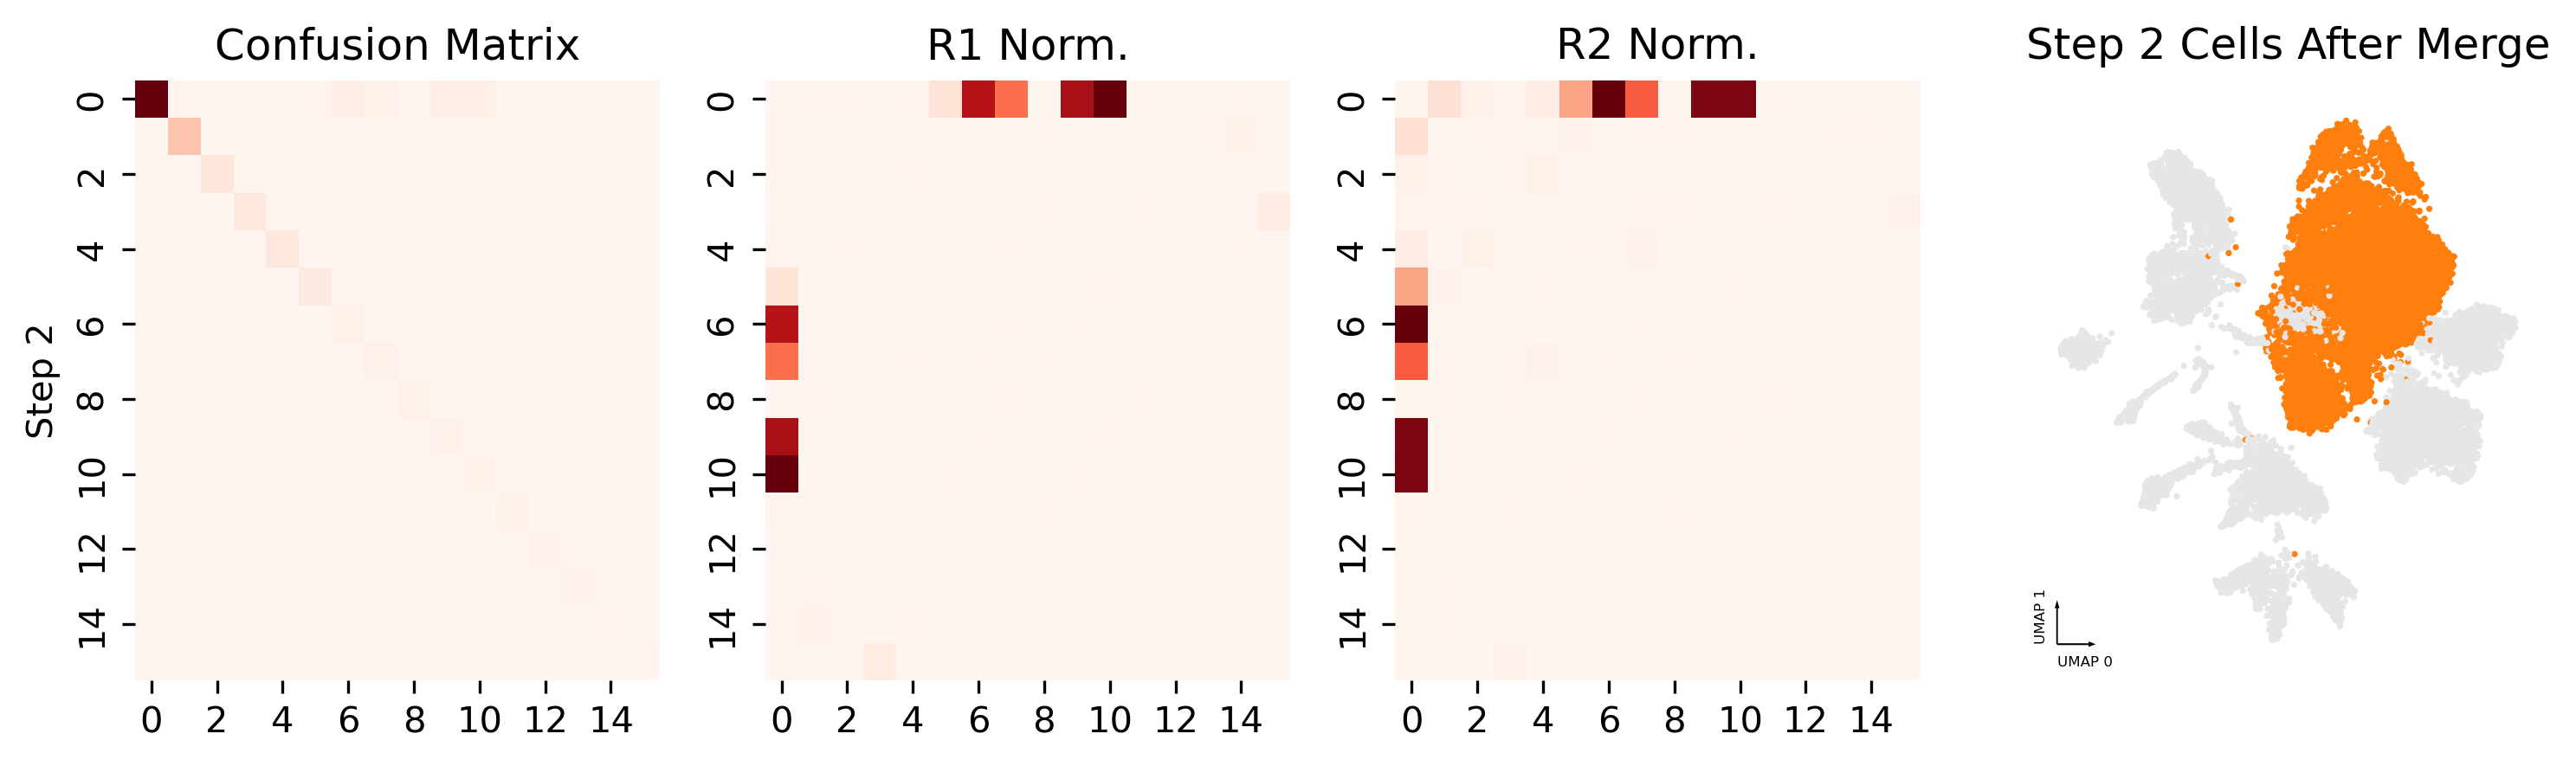

In [31]:
cc.plot_steps(coord_data=adata.obs, coord_base=coord_base)

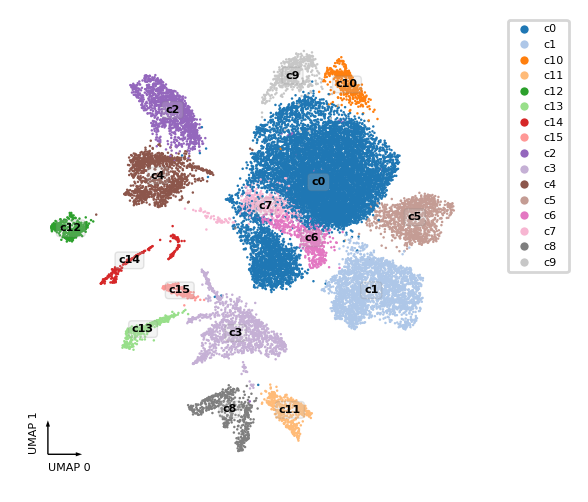

In [32]:
adata.obs[clustering_name] = cc.label

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
_ = categorical_scatter(
    data=adata.obs,
    ax=ax,
    hue=clustering_name,
    coord_base=coord_base,
    palette="tab20",
    text_anno=clustering_name,
    show_legend=True
)

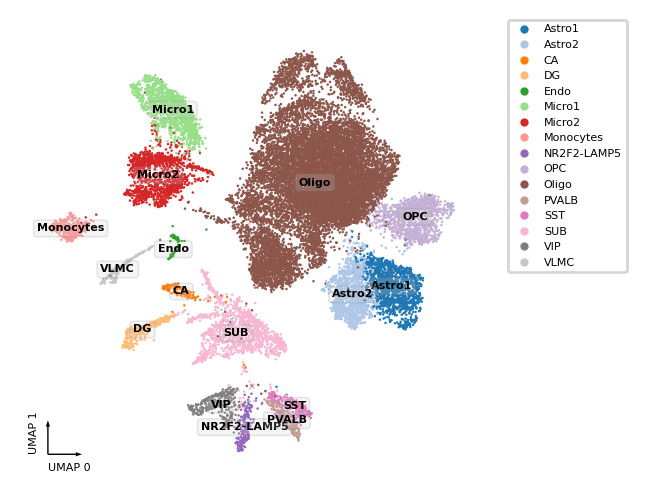

In [4]:
# adata.obs[clustering_name] = cc.label

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
_ = categorical_scatter(
    data=adata.obs,
    ax=ax,
    hue="final_cluster",
    coord_base=coord_base,
    palette="tab20",
    text_anno="final_cluster",
    show_legend=True
)
plt.savefig("results/mono_all.pdf", dpi=300, bbox_inches="tight")

In [33]:
adata.write_h5ad(adata_path)